<h1> GAN comparison on Kaggle Credit Card Fraud Data </h1><br>

Cody Nash<br>
Development notebook<br>
<hr>

<a id="TOC"></a><h2>Table of Contents</h2>
<br>
<a href='#Setup'> Setup</a><br>
<br>
<a href="#Waya.ai GAN dense"> Waya.ai GAN dense</a><br>
<br>
<a href="#Waya.ai CGAN dense"> Waya.ai CGAN dense</a><br>
<br>
<a href="#Waya.ai WGAN dense"> Waya.ai WGAN dense</a><br>
<br>
<a href="#Waya.ai WCGAN dense"> Waya.ai WCGAN dense</a><br>
<br>
<a href="#Summary"> Summary</a><br>
<br>

<a id="Setup"><h1>Setup</h1></a>

<a href='#TOC'>Table of contents</a>
<br><br>

- Load basic libraries
- Load common functions
- Load stored datasets

In [1]:
# Linux for xgboost and tensorflow

In [2]:
import psutil ; print(list(psutil.virtual_memory())[0:2])

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns

import xgboost as xgb

import pickle

import gc
gc.collect()
print(list(psutil.virtual_memory())[0:2])

[4041883648, 3443154944]
[4041883648, 3383119872]


In [3]:
def BaseMetrics(y_pred,y_true):
    TP = np.sum( (y_pred == 1) & (y_true == 1) )
    TN = np.sum( (y_pred == 0) & (y_true == 0) )
    FP = np.sum( (y_pred == 1) & (y_true == 0) )
    FN = np.sum( (y_pred == 0) & (y_true == 1) )
    return TP, TN, FP, FN

def SimpleMetrics(y_pred,y_true):
    TP, TN, FP, FN = BaseMetrics(y_pred,y_true)
    ACC = ( TP + TN ) / ( TP + TN + FP + FN )
    
    # Reporting
    from IPython.display import display
    print( 'Confusion Matrix')
    display( pd.DataFrame( [[TN,FP],[FN,TP]], columns=['Pred 0','Pred 1'], index=['True 0', 'True 1'] ) )
    print( 'Accuracy : {}'.format( ACC ))
    
def SimpleAccuracy(y_pred,y_true):
    TP, TN, FP, FN = BaseMetrics(y_pred,y_true)
    ACC = ( TP + TN ) / ( TP + TN + FP + FN )
    return ACC


In [4]:
def get_data_batch(train, batch_size, data_dim):
    x = train.loc[ np.random.choice(train.index, batch_size) ].values
    return np.reshape(x, (batch_size, data_dim) )

In [5]:
def CheckAccuracy( generator_model, n_samples, train ):
    np.random.seed(0)
    temp_noise = np.random.normal(size=(n_samples*2, rand_dim)) 
    test_samples = generator_model.predict(temp_noise)

    test_samples = np.reshape(test_samples, (n_samples*2, data_dim))
    
    test_samples = pd.DataFrame(test_samples,columns=train.columns)
    test_samples['syn_label'] = 1
    try:
        test_samples['Class'] = (test_samples['Class'] > 0.5)*1
    except:
        None

    real_samples = train.sample(n_samples*2,replace=False)
    real_samples['syn_label'] = 0
    train_df = pd.concat([real_samples[:n_samples],test_samples[:n_samples]],axis=0)
    test_df = pd.concat([real_samples[n_samples:],test_samples[n_samples:]],axis=0)

    X_col = test_df.columns[:-1]
    y_col = test_df.columns[-1]
    dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)

    xgb_params = {
        'max_depth': 4,
        'objective': 'binary:logistic',
        'random_state': 0 }
    xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10)

    y_pred = np.round(xgb_test.predict(dtest))
    y_true = test_df['syn_label']
#     print('ACC: {:.3f}'.format(SimpleAccuracy(y_pred, y_true)))
    return '{:.2f}'.format(SimpleAccuracy(y_pred, y_true))

In [6]:
import os
import sys

from keras import applications
from keras import backend as K
from keras import layers
from keras import models
from keras import optimizers
# from keras.preprocessing import image
import numpy as np
# from PIL import Image
import tensorflow as tf

# # from dlutils import plot_image_batch_w_labels

# import ResNeXt

Using TensorFlow backend.


In [7]:
#
# directory paths
#

path = '' # os.path.dirname(os.path.abspath(__file__))
cache_dir = os.path.join(path, 'cache')

#
# generator input params
#

rand_dim = 32 # 64  # dimension of the generator's input tensor (gaussian noise)

#
# image dimensions
#

data_dim = 28

#
# training params
#

nb_steps = 5001 # 50000
batch_size = 64 # 64
k_d = 5 # 5  # number of critic network updates per adversarial training step
k_g = 1  # number of generator network updates per adversarial training step
critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training

#
# logging params
#

log_interval = 10 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
fixed_noise = np.random.normal(size=(batch_size, rand_dim))  # fixed noise to generate batches of generated images

In [8]:
#
# generator and discriminator architecture from: https://github.com/buriburisuri/ac-gan
#

neurons_per_layer = 32

def add_common_layers(y):
#     y = layers.LeakyReLU()(y)
    y = layers.advanced_activations.LeakyReLU()(y)
    y = layers.Dropout(0.25)(y)
    return y

def generator_network(x):
    x = layers.Dense(neurons_per_layer)(x)
    x = add_common_layers(x)

    x = layers.Dense(neurons_per_layer)(x)
    x = add_common_layers(x)

    x = layers.Dense(data_dim)(x)
    
    return x

def discriminator_network(x):

    x = layers.Dense(data_dim)(x)
    x = add_common_layers(x)

    x = layers.Dense(neurons_per_layer)(x)
    x = add_common_layers(x)
    
    x = layers.Dense(neurons_per_layer)(x)
    x = add_common_layers(x)

    return layers.Dense(1)(x)


In [9]:
%%time
# Test loading credit card data
# https://www.kaggle.com/dalpozz/creditcardfraud

data = pd.read_csv("data/creditcard.csv.zip")
print(data.shape)
# data.head(3)

(284807, 31)
CPU times: user 3.86 s, sys: 570 ms, total: 4.43 s
Wall time: 5.31 s


In [10]:
data_cols = [ i for i in data.columns if 'V' in i ]
print('# of data columns: ',len(data_cols))
label_cols = ['Class']

# of data columns:  28


In [11]:

# # Center on 0.5 with N standard deviations covering the range from 0 to 1

# N = 20
# data[ data_cols ] = data[ data_cols ] / data[ data_cols ].std() / N + 0.5
# data[ data_cols ] = data[ data_cols ].clip(0,1)

In [12]:

# # Scale to 0 to 1 with no filtering

# from sklearn.preprocessing import MinMaxScaler
# MMS = MinMaxScaler()
# MMS.fit(train)
# train = pd.DataFrame( MMS.transform(train), columns=train.columns )

In [13]:

# padding = 4 # To get 32 columns for 4 x 8 for convolutions

# # Generators will waste time learning these values.

# pad0 = pd.DataFrame(np.ones((train.shape[0],padding))/2,columns=[ 'p'+str(i) for i in range(padding) ])
# train = pd.concat([train,pad0],axis=1)
# print(train.shape)


In [13]:

# Select all fraud data and a random sample of non-fraud data of the same size for a balanced dataset

train_fraction = 1

np.random.seed(5)
train = data.loc[ data['Class']==1, data_cols ].copy().reset_index(drop=True)
# train_int = int(len(train)*train_fraction)

# test = train[train_int:]
# train = train[:train_int]

normal = data.loc[ data['Class']==0, data_cols ]
# train_normal = normal.loc[ np.random.choice(normal.index, (len(train)+len(test))*100, replace=False) ].reset_index(drop=True)
train_normal = normal.loc[ np.random.choice(normal.index, len(train), replace=False) ].reset_index(drop=True)

# train = pd.concat( [ train, train_normal[:train_int] ] ).reset_index(drop=True)
# test = pd.concat( [ test, train_normal[train_int:] ] ).reset_index(drop=True)
train = pd.concat( [ train, train_normal ] ).reset_index(drop=True)

print(train.shape)
# print(test.shape)

(984, 28)


In [14]:

# Select all fraud data and a random sample of non-fraud data of the same size for a balanced dataset
data_cols_w_class = data_cols + ['Class']

np.random.seed(5)
train_w_class = data.loc[ data['Class']==1, data_cols_w_class ].copy().reset_index(drop=True)
# test_w_class = train_w_class[train_int:]
# train_w_class = train_w_class[:train_int]

normal_w_class = data.loc[ data['Class']==0, data_cols_w_class ]
# train_normal_w_class = normal_w_class.loc[ np.random.choice(normal_w_class.index, (len(train_w_class)+len(test_w_class))*100, replace=False) ].reset_index(drop=True)
train_normal_w_class = normal_w_class.loc[ np.random.choice(normal_w_class.index, len(train_w_class), replace=False) ].reset_index(drop=True)

# train_w_class = pd.concat( [ train_w_class, train_normal_w_class[:train_int] ] ).reset_index(drop=True)
# test_w_class = pd.concat( [ test_w_class, train_normal_w_class[train_int:] ] ).reset_index(drop=True)
train_w_class = pd.concat( [ train_w_class, train_normal_w_class ] ).reset_index(drop=True)

print(train_w_class.shape)
# print(test_w_class.shape)

(984, 29)


In [15]:

# # Select all fraud data and a random sample of non-fraud data of the same size for a balanced dataset

# train_fraction = 1

# np.random.seed(5)
# train = data.loc[ data['Class']==1, data_cols ].copy().reset_index(drop=True)
# train_int = int(len(train)*train_fraction)

# test = train[train_int:]
# train = train[:train_int]

# normal = data.loc[ data['Class']==0, data_cols ]
# train_normal = normal.loc[ np.random.choice(normal.index, len(train)+len(test), replace=False) ].reset_index(drop=True)

# train = pd.concat( [ train, train_normal[:train_int] ] ).reset_index(drop=True)
# test = pd.concat( [ test, train_normal[train_int:] ] ).reset_index(drop=True)

# print(train.shape)
# print(test.shape)

In [16]:

# # Select all fraud data and a random sample of non-fraud data of the same size for a balanced dataset
# data_cols_w_class = data_cols + ['Class']

# np.random.seed(5)
# train_w_class = data.loc[ data['Class']==1, data_cols_w_class ].copy().reset_index(drop=True)
# test_w_class = train_w_class[train_int:]
# train_w_class = train_w_class[:train_int]

# normal_w_class = data.loc[ data['Class']==0, data_cols_w_class ]
# train_normal_w_class = normal_w_class.loc[ np.random.choice(normal_w_class.index, len(train_w_class)+len(test_w_class), replace=False) ].reset_index(drop=True)

# train_w_class = pd.concat( [ train_w_class, train_normal_w_class[:train_int] ] ).reset_index(drop=True)
# test_w_class = pd.concat( [ test_w_class, train_normal_w_class[train_int:] ] ).reset_index(drop=True)

# print(train_w_class.shape)
# print(test_w_class.shape)

<a id="EDA"><h1>EDA</h1></a>

<a href='#TOC'>Table of contents</a>
<br><br>

In [8]:
%%time
# Test loading credit card data
# https://www.kaggle.com/dalpozz/creditcardfraud

data = pd.read_csv("data/creditcard.csv.zip")
print(data.shape)
# data.head(3)

(284807, 31)
CPU times: user 3.57 s, sys: 340 ms, total: 3.91 s
Wall time: 4.48 s


In [9]:
data_cols = [ i for i in data.columns if 'V' in i ]
print('# of data columns: ',len(data_cols))
label_cols = ['Class']

# of data columns:  28


In [10]:
data.groupby(label_cols)[label_cols].count()

,Class
Class,
0,284315
1,492


In [11]:
# Total nulls in dataset
data.isnull().sum().sum()

0

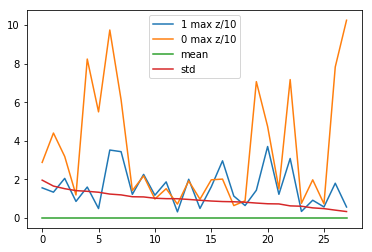

In [12]:
# There are outliers
# plt.plot( np.log10( data[ data_cols ].abs().max().values ) )
# plt.plot( data[ data_cols ].abs().max().values / data[ data_cols ].std().values / 10, label='max z/10' )
plt.plot( data.loc[ data.Class==1, data_cols ].abs().max().values / data[ data_cols ].std().values / 10, label='1 max z/10' )
plt.plot( data.loc[ data.Class==0, data_cols ].abs().max().values / data[ data_cols ].std().values / 10, label='0 max z/10' )
plt.plot( data[ data_cols ].mean().values, label='mean' )
# plt.plot( data[ data_cols ].abs().mean().values, label='abs mean' )
plt.plot( data[ data_cols ].std().values, label='std' )
plt.legend() ; 

In [13]:
# Duplicates?
sum( data.duplicated() )

1081

In [14]:
sum( data.loc[ data.Class==0 ].duplicated() ), \
sum( data.loc[ data.Class==1 ].duplicated() )

(1062, 19)

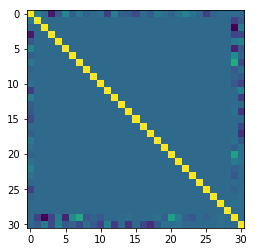

In [15]:
# # Check Correlations
corr0 = data.corr()
plt.imshow(corr0)

In [14]:
# np.round(corr0[['Time','Amount','Class']],3)
# corr0[data_cols]
# np.round(corr0[data_cols],1)
# np.round(corr0[data_cols],1)


In [15]:
# from sklearn import metrics
# MIS = []
# # for i in range(len(data_cols)):
# for i in range(len(data.columns)):
#     temp = []
# #     for j in range(i+1,len(data_cols)):
#     for j in range(i+1,len(data.columns)):
# #         temp += [ metrics.mutual_info_score( data[data_cols[i]], data[data_cols[j]] )]
#         temp += [ metrics.mutual_info_score( data[data.columns[i]], data[data.columns[j]] )]
#     MIS += [temp]
#     print(data_cols[i],np.round(temp,1))
#     break

In [19]:
# # https://stackoverflow.com/questions/22227165/catch-matplotlib-warning
# # import warnings
# # with warnings.catch_warnings():
# # #     warnings.simplefilter("ignore")    
# #     warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# f, axarr = plt.subplots(7, 4, figsize=(14,10) )
# for i, col in enumerate(data_cols):
#     axarr[i//4, i%4].hist( data[col], bins=20 )
#     axarr[i//4, i%4].set_title( '{}'.format(col) )
# #     axarr[i//4, i%4].set_xlim([-0.1,1.1])
# #     axarr[i//4, i%4].set_ylim([0,40])
# f.set_tight_layout(True)

# # data[ data_cols ].plot.hist( subplots=True, bins=20, figsize=(14,5) )
# # plt.tight_layout(True) ;

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


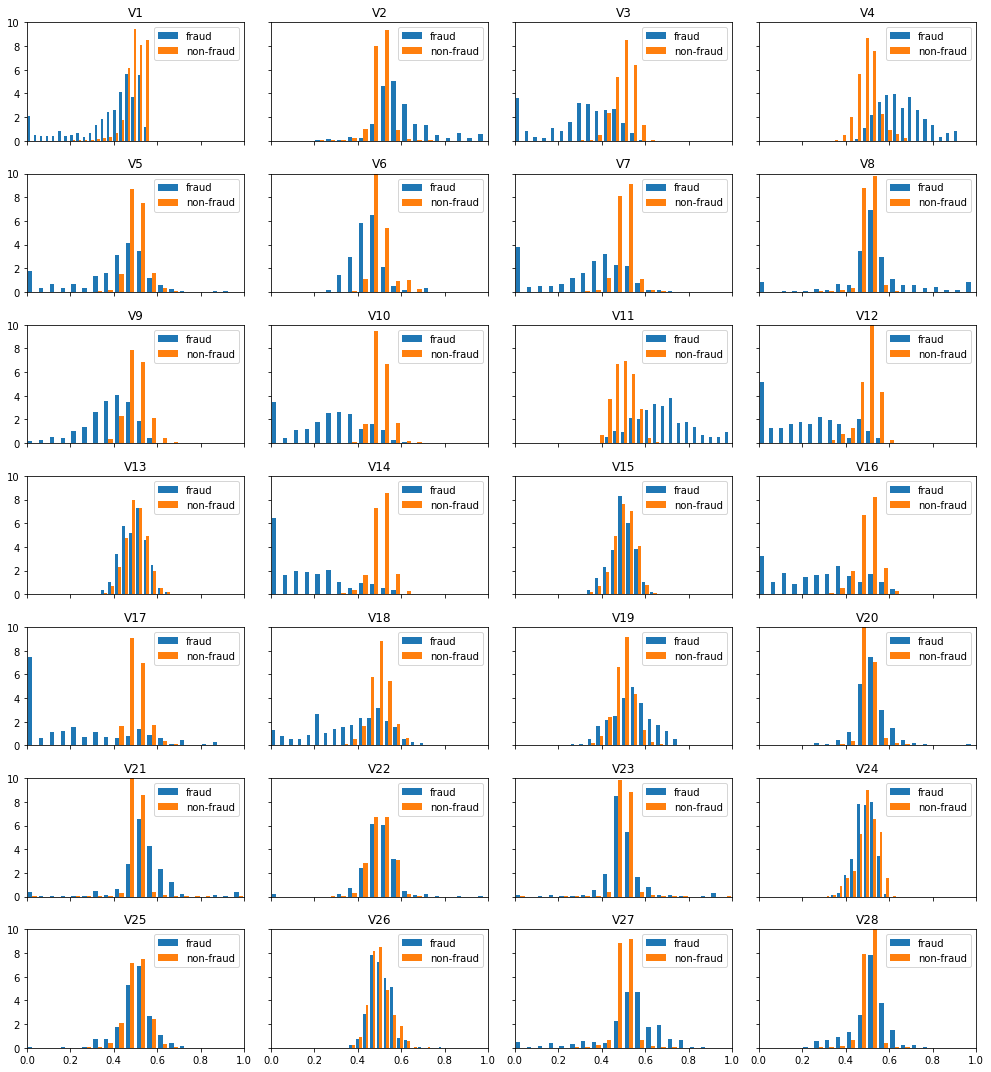

In [133]:
f, axarr = plt.subplots(7, 4, figsize=(14,15) )
for i, col in enumerate(data_cols):
    axarr[i//4, i%4].hist( [ data.loc[ data.Class == 1, col ], data.loc[ data.Class == 0, col ] ], label=['fraud','non-fraud'], bins=20, normed=True )
    axarr[i//4, i%4].set_title( '{}'.format(col) )
    axarr[i//4, i%4].legend()
    if i//4 != 6: axarr[i//4, i%4].tick_params(axis='x',labelbottom='off')
    if i%4 != 0 : axarr[i//4, i%4].tick_params(axis='y',labelleft='off')
    axarr[i//4, i%4].set_xlim([0,1])
    axarr[i//4, i%4].set_ylim([0,10])
f.set_tight_layout(True)
plt.show()

In [123]:
# data.groupby('Class')[ data_cols ].describe()

In [69]:
# n_fraud = np.sum(data['Class']==1)

# f, axarr = plt.subplots(7, 4, figsize=(14,15) )
# for i, col in enumerate(data_cols):
#     axarr[i//4, i%4].hist( [train[col][:n_fraud], train[col][n_fraud:]], label=['fraud','non-fraud'], bins=20, normed=True )
#     axarr[i//4, i%4].set_title( '{}'.format(col) )
#     axarr[i//4, i%4].legend()
#     if i//4 != 6: axarr[i//4, i%4].tick_params(axis='x',labelbottom='off')
#     if i%4 != 0 : axarr[i//4, i%4].tick_params(axis='y',labelleft='off')
#     axarr[i//4, i%4].set_xlim([0,1])
#     axarr[i//4, i%4].set_ylim([0,10])
# f.set_tight_layout(True)
# plt.show()

<a id="Waya.ai GAN dense"><h1>Waya.ai GAN dense</h1></a>

<a href='#TOC'>Table of contents</a>

In [270]:
data_dim = 28

In [271]:
def adversarial_training(data_dir, generator_model_path, discriminator_model_path, evaluate=False):
    """
    Adversarial training of the generator network Gθ and discriminator network Dφ.

    """
    # Set random seed
    np.random.seed(5)
    
    #
    # define model input and output tensors
    #

    generator_input_tensor = layers.Input(shape=(rand_dim, ))
    generated_image_tensor = generator_network(generator_input_tensor)

    generated_or_real_image_tensor = layers.Input(shape=(data_dim,))
    discriminator_output = discriminator_network(generated_or_real_image_tensor)

    #
    # define models
    #

    generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')
    discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
                                       outputs=[discriminator_output],
                                       name='discriminator')

    combined_output = discriminator_model(generator_model(generator_input_tensor))
    combined_model = models.Model(inputs=[generator_input_tensor], outputs=[combined_output], name='combined')

    #
    # compile models
    #

    adam = optimizers.Adam(lr=.0001, beta_1=0.5, beta_2=0.9)

    generator_model.compile(optimizer=adam, loss='binary_crossentropy')
    discriminator_model.compile(optimizer=adam, loss='binary_crossentropy')
    
    discriminator_model.trainable = False
#     combined_model.compile(optimizer=adam, loss=[em_loss])
    combined_model.compile(optimizer=adam, loss='binary_crossentropy')
    
    print(generator_model.summary())
    print(discriminator_model.summary())
    print(combined_model.summary())


#     disc_loss = []
#     combined_loss = []
    combined_loss = np.empty(shape=1)
    disc_loss_real = np.empty(shape=1)
    disc_loss_generated = np.empty(shape=1)
    xgb_losses = np.empty(shape=1)
    
    if generator_model_path:
        generator_model.load_weights(generator_model_path, by_name=True)
    if discriminator_model_path:
        discriminator_model.load_weights(discriminator_model_path, by_name=True)
    
    for i in range(nb_steps):
        print('Step: {} of {}.'.format(i, nb_steps))
        K.set_learning_phase(1) # 1 = train

        # train the discriminator
        for _ in range(k_d):
            # sample a mini-batch of noise (generator input)
            z = np.random.normal(size=(batch_size, rand_dim))

            # sample a mini-batch of real images
            x = get_data_batch(train, batch_size, data_dim)

            # generate a batch of images with the current generator
            g_z = generator_model.predict(z)

            # update φ by taking an SGD step on mini-batch loss LD(φ)
            disc_loss_real = np.append(disc_loss_real, discriminator_model.train_on_batch(x, np.random.uniform(
                low=0.7, high=1.2, size=batch_size)))
            disc_loss_generated = np.append(disc_loss_generated, discriminator_model.train_on_batch(g_z,
                np.random.uniform(low=0.0, high=0.3, size=batch_size)))


        # train the generator
        for _ in range(k_g):
            z = np.random.normal(loc=0.0, scale=1.0, size=(batch_size, rand_dim))
            # update θ by taking an SGD step on mini-batch loss LR(θ)
            combined_loss = np.append(combined_loss, combined_model.train_on_batch(z, np.random.uniform(
                low=0.7, high=1.2, size=batch_size)))

        if not i % log_interval and i != 0:
            K.set_learning_phase(0) # 0 = test

#             g_z = generator_model.predict(fixed_noise)

#             x = get_data_batch(train, batch_size, data_dim)

            # log loss summary
            print('Generator model loss: {}.'.format(np.mean(combined_loss[-log_interval:], axis=0)))
            print('Discriminator model loss real: {}.'.format(np.mean(disc_loss_real[-log_interval:], axis=0)))
            print('Discriminator model loss generated: {}.'.format(np.mean(disc_loss_generated[-log_interval:], axis=0)))
            
            
            xgb_loss = CheckAccuracy( generator_model, 100, train )
#             xgb_loss = CheckAccuracy( generator_model, 100, test )
            xgb_losses = np.append(xgb_losses, xgb_loss)
            print('xgboost accuracy: {}'.format(xgb_loss) )

            # save model checkpoints
            model_checkpoint_base_name = os.path.join(cache_dir, 'GAN_{}_model_weights_step_{}.h5')
            generator_model.save_weights(model_checkpoint_base_name.format('generator', i))
            discriminator_model.save_weights(model_checkpoint_base_name.format('discriminator', i))
    
    pickle.dump([combined_loss, disc_loss_real, disc_loss_generated, xgb_losses], 
                open(os.path.join(cache_dir, 'GAN_losses.pkl'),'wb'))

In [272]:
%%time
K.set_learning_phase(1) # 1 = train
adversarial_training('', None, None)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        (None, 32)                0         
_________________________________________________________________
dense_158 (Dense)            (None, 32)                1056      
_________________________________________________________________
leaky_re_lu_111 (LeakyReLU)  (None, 32)                0         
_________________________________________________________________
dropout_111 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_159 (Dense)            (None, 32)                1056      
_________________________________________________________________
leaky_re_lu_112 (LeakyReLU)  (None, 32)                0         
_________________________________________________________________
dropout_112 (Dropout)        (None, 32)                0         
__________

/opt/conda/lib/python3.6/site-packages/Keras-2.0.4-py3.6.egg/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Step: 1 of 5001.
Step: 2 of 5001.
Step: 3 of 5001.
Step: 4 of 5001.
Step: 5 of 5001.
Step: 6 of 5001.
Step: 7 of 5001.
Step: 8 of 5001.
Step: 9 of 5001.
Step: 10 of 5001.
Generator model loss: 8.52297601699829.
Discriminator model loss real: 5.481720447540283.
Discriminator model loss generated: 2.5841670632362366.
xgboost accuracy: 0.96
Step: 11 of 5001.
Step: 12 of 5001.
Step: 13 of 5001.
Step: 14 of 5001.
Step: 15 of 5001.
Step: 16 of 5001.
Step: 17 of 5001.
Step: 18 of 5001.
Step: 19 of 5001.
Step: 20 of 5001.
Generator model loss: 7.576701498031616.
Discriminator model loss real: 4.11926531791687.
Discriminator model loss generated: 2.2801565647125246.
xgboost accuracy: 0.95
Step: 21 of 5001.
Step: 22 of 5001.
Step: 23 of 5001.
Step: 24 of 5001.
Step: 25 of 5001.
Step: 26 of 5001.
Step: 27 of 5001.
Step: 28 of 5001.
Step: 29 of 5001.
Step: 30 of 5001.
Generator model loss: 7.320602130889893.
Discriminator model loss real: 3.8863959074020387.
Discriminator model loss generated: 2.3

In [273]:
# for continued training
# adversarial_training('', 'cache/GAN_generator_model_weights_step_100.h5', 'cache/GAN_discriminator_model_weights_step_100.h5')

In [274]:
[combined_loss, disc_loss_real, disc_loss_generated, xgb_losses] = pickle.load(open(os.path.join(cache_dir, 'GAN_losses.pkl'),'rb'))

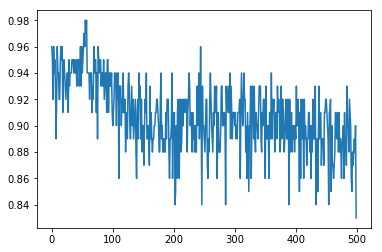

In [275]:
plt.plot( xgb_losses[1:] ) ;

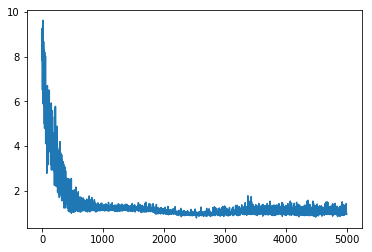

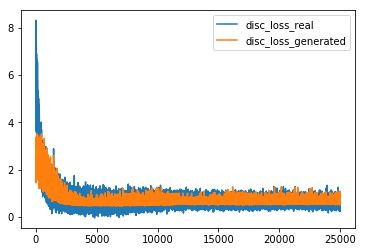

In [276]:
plt.plot( combined_loss[1:], label='combined_loss' ) ; plt.show()

plt.plot( disc_loss_real[1:], label='disc_loss_real' )
plt.plot( disc_loss_generated[1:], label='disc_loss_generated' )
plt.legend() ;

In [277]:
np.random.seed(0)
    
generator_input_tensor = layers.Input(shape=(rand_dim, ))
generated_image_tensor = generator_network(generator_input_tensor)
generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')

generator_model.load_weights('cache/GAN_generator_model_weights_step_5000.h5')

temp_noise = np.random.normal(size=(batch_size, rand_dim))  # fixed noise to generate batches of generated images

g_z = generator_model.predict(temp_noise)

# g_z[0]


/opt/conda/lib/python3.6/site-packages/Keras-2.0.4-py3.6.egg/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


In [278]:
print( CheckAccuracy( generator_model, 100, train ) )

0.89


In [279]:
n_samples = 100

np.random.seed(0)
temp_noise = np.random.normal(size=(n_samples*2, rand_dim))  # fixed noise to generate batches of generated images
test_samples = generator_model.predict(temp_noise)
test_samples = np.reshape(test_samples, (n_samples*2, data_dim))
test_samples = pd.DataFrame(test_samples,columns=train.columns)
test_samples['syn_label'] = 1

# real_samples = test.sample(n_samples*2,replace=False)
real_samples = train.sample(n_samples*2,replace=False)
real_samples['syn_label'] = 0

train_df = pd.concat([real_samples[:n_samples],test_samples[:n_samples]],axis=0)
test_df = pd.concat([real_samples[n_samples:],test_samples[n_samples:]],axis=0)

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)

xgb_params = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0 }
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred = np.round(xgb_test.predict(dtest))
y_true = test_df['syn_label']
'{:.2f}'.format(SimpleAccuracy(y_pred, y_true))

'0.89'

In [280]:
# Evaluate performance on validation set
SimpleMetrics(y_pred,y_true)

Confusion Matrix


,Pred 0,Pred 1
True 0,92,8
True 1,14,86


Accuracy : 0.89


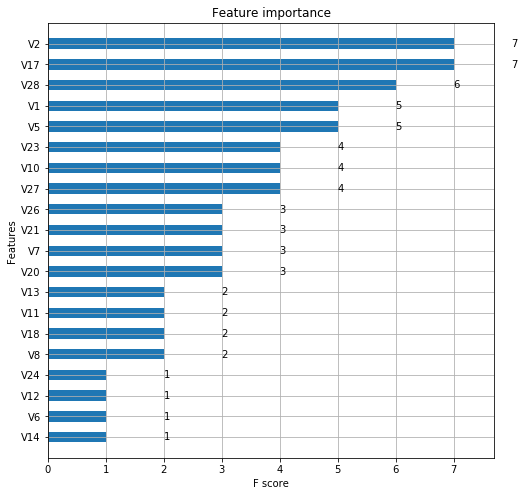

In [281]:
# Plot feature importances

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=20, height=0.5, ax=ax);

In [231]:
# # https://stackoverflow.com/questions/613183/sort-a-python-dictionary-by-value
# import operator
# x = xgb_test.get_fscore()
# sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
# # sorted_x

In [232]:
# for col, imp in sorted_x:
# # for col in xgb_model_DCGAN.get_fscore().keys():
# # for col in ['V1','V14','V3']:
#     plt.hist( [train_df[col][:100], train_df[col][100:]], label=['real','syn'], bins=20 )
# #     plt.title( '{}: {}'.format(col, xgb_model_DCGAN.get_fscore()[col]) )
#     plt.title( '{}: {}'.format(col, imp) )
#     plt.legend() ; plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


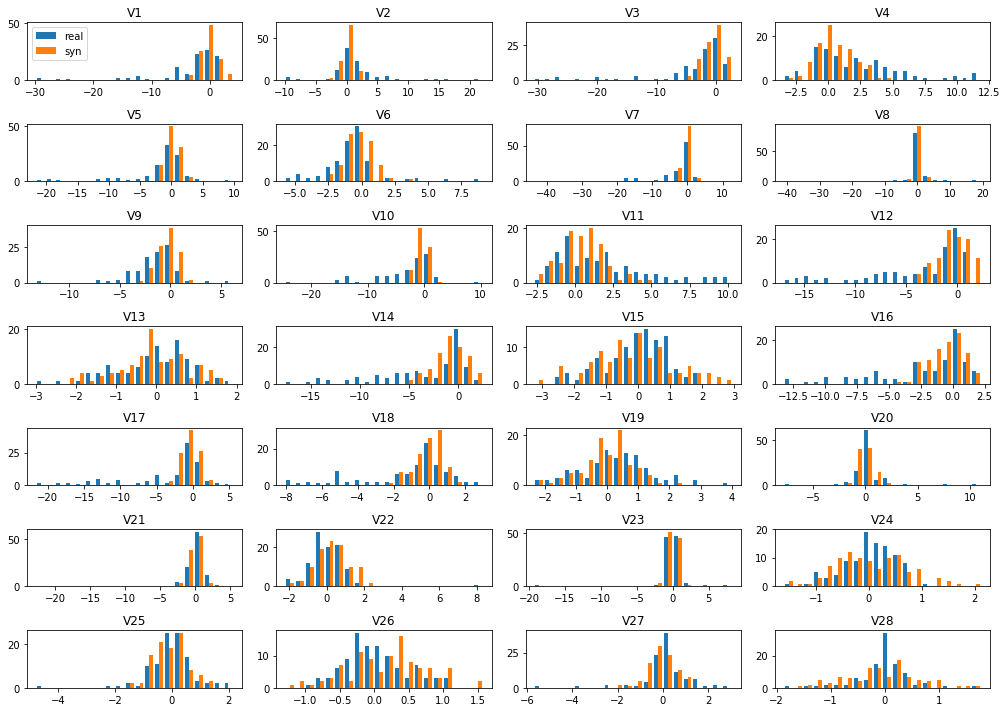

In [282]:
# for col in train.columns:
#     plt.hist( [train_df[col][:100], train_df[col][100:]], label=['real','syn'], bins=20 )
#     plt.title( '{}'.format(col) )
#     plt.legend() ; plt.show()
    
# plt.figure(figsize=(14,5))    
f, axarr = plt.subplots(7, 4, figsize=(14,10) )
for i in range(28):
    col = train_df.columns[i]
    axarr[i//4, i%4].hist( [train_df[col][:100], train_df[col][100:]], label=['real','syn'], bins=20 )
    axarr[i//4, i%4].set_title( '{}'.format(col) )
    if i == 0: axarr[i//4, i%4].legend()
#     axarr[i//4, i%4].set_xlim([-0.1,1.1])
#     axarr[i//4, i%4].set_ylim([0,40])
f.set_tight_layout(True)

<a id="Waya.ai CGAN dense"><h1>Waya.ai CGAN dense</h1></a>

<a href='#TOC'>Table of contents</a>

In [18]:
data_dim = 29

In [20]:
def adversarial_training(data_dir, generator_model_path, discriminator_model_path, evaluate=False):
    """
    Adversarial training of the generator network Gθ and discriminator network Dφ.

    """
    # Set random seed
    np.random.seed(5)
    
    #
    # define model input and output tensors
    #

    generator_input_tensor = layers.Input(shape=(rand_dim, ))
    generated_image_tensor = generator_network(generator_input_tensor)

    generated_or_real_image_tensor = layers.Input(shape=(data_dim,))
    discriminator_output = discriminator_network(generated_or_real_image_tensor)

    #
    # define models
    #

    generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')
    discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
                                       outputs=[discriminator_output],
                                       name='discriminator')

    combined_output = discriminator_model(generator_model(generator_input_tensor))
    combined_model = models.Model(inputs=[generator_input_tensor], outputs=[combined_output], name='combined')

    #
    # compile models
    #

    adam = optimizers.Adam(lr=.0001, beta_1=0.5, beta_2=0.9)

    generator_model.compile(optimizer=adam, loss='binary_crossentropy')
    discriminator_model.compile(optimizer=adam, loss='binary_crossentropy')
    
    discriminator_model.trainable = False
#     combined_model.compile(optimizer=adam, loss=[em_loss])
    combined_model.compile(optimizer=adam, loss='binary_crossentropy')
    
    print(generator_model.summary())
    print(discriminator_model.summary())
    print(combined_model.summary())


#     disc_loss = []
#     combined_loss = []
    combined_loss = np.empty(shape=1)
    disc_loss_real = np.empty(shape=1)
    disc_loss_generated = np.empty(shape=1)
    xgb_losses = np.empty(shape=1)
    
    if generator_model_path:
        generator_model.load_weights(generator_model_path, by_name=True)
    if discriminator_model_path:
        discriminator_model.load_weights(discriminator_model_path, by_name=True)
    
    for i in range(nb_steps):
        print('Step: {} of {}.'.format(i, nb_steps))
        K.set_learning_phase(1) # 1 = train

        # train the discriminator
        for _ in range(k_d):
            # sample a mini-batch of noise (generator input)
            z = np.random.normal(size=(batch_size, rand_dim))

            # sample a mini-batch of real images
            x = get_data_batch(train_w_class, batch_size, data_dim)

            # generate a batch of images with the current generator
            g_z = generator_model.predict(z)

            # update φ by taking an SGD step on mini-batch loss LD(φ)
            disc_loss_real = np.append(disc_loss_real, discriminator_model.train_on_batch(x, np.random.uniform(
                low=0.7, high=1.2, size=batch_size)))
            disc_loss_generated = np.append(disc_loss_generated, discriminator_model.train_on_batch(g_z,
                np.random.uniform(low=0.0, high=0.3, size=batch_size)))


        # train the generator
        for _ in range(k_g):
            z = np.random.normal(loc=0.0, scale=1.0, size=(batch_size, rand_dim))
            # update θ by taking an SGD step on mini-batch loss LR(θ)
            combined_loss = np.append(combined_loss, combined_model.train_on_batch(z, np.random.uniform(
                low=0.7, high=1.2, size=batch_size)))

        if not i % log_interval and i != 0:
            K.set_learning_phase(0) # 0 = test

            # log loss summary
            print('Generator model loss: {}.'.format(np.mean(combined_loss[-log_interval:], axis=0)))
            print('Discriminator model loss real: {}.'.format(np.mean(disc_loss_real[-log_interval:], axis=0)))
            print('Discriminator model loss generated: {}.'.format(np.mean(disc_loss_generated[-log_interval:], axis=0)))
            
            
            xgb_loss = CheckAccuracy( generator_model, 400, train_w_class )
#             xgb_loss = CheckAccuracy( generator_model, 100, test )
            xgb_losses = np.append(xgb_losses, xgb_loss)
            print('xgboost accuracy: {}'.format(xgb_loss) )

            # save model checkpoints
            model_checkpoint_base_name = os.path.join(cache_dir, 'CGAN_{}_model_weights_step_{}.h5')
            generator_model.save_weights(model_checkpoint_base_name.format('generator', i))
            discriminator_model.save_weights(model_checkpoint_base_name.format('discriminator', i))
    
    pickle.dump([combined_loss, disc_loss_real, disc_loss_generated, xgb_losses], 
                open(os.path.join(cache_dir, 'CGAN_losses.pkl'),'wb'))

In [ ]:
%%time
K.set_learning_phase(1) # 1 = train
adversarial_training('', None, None)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
__________

/opt/conda/lib/python3.6/site-packages/Keras-2.0.4-py3.6.egg/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Step: 1 of 5001.
Step: 2 of 5001.
Step: 3 of 5001.
Step: 4 of 5001.
Step: 5 of 5001.
Step: 6 of 5001.
Step: 7 of 5001.
Step: 8 of 5001.
Step: 9 of 5001.
Step: 10 of 5001.
Generator model loss: 5.978703880310059.
Discriminator model loss real: 7.393591451644897.
Discriminator model loss generated: 2.143365812301636.
xgboost accuracy: 0.96
Step: 11 of 5001.
Step: 12 of 5001.
Step: 13 of 5001.
Step: 14 of 5001.
Step: 15 of 5001.
Step: 16 of 5001.
Step: 17 of 5001.
Step: 18 of 5001.
Step: 19 of 5001.
Step: 20 of 5001.
Generator model loss: 4.808601236343383.
Discriminator model loss real: 5.247726774215698.
Discriminator model loss generated: 1.9485689282417298.
xgboost accuracy: 0.96
Step: 21 of 5001.
Step: 22 of 5001.
Step: 23 of 5001.
Step: 24 of 5001.
Step: 25 of 5001.
Step: 26 of 5001.
Step: 27 of 5001.
Step: 28 of 5001.
Step: 29 of 5001.
Step: 30 of 5001.
Generator model loss: 4.994474029541015.
Discriminator model loss real: 4.5369186162948605.
Discriminator model loss generated: 2.

In [289]:
# for continued training
# adversarial_training('', 'cache/CGAN_generator_model_weights_step_100.h5', 'cache/CGAN_discriminator_model_weights_step_100.h5')

In [290]:
[combined_loss, disc_loss_real, disc_loss_generated, xgb_losses] = pickle.load(open(os.path.join(cache_dir, 'CGAN_losses.pkl'),'rb'))

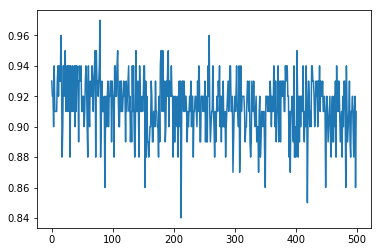

In [291]:
plt.plot( xgb_losses[1:] ) ;

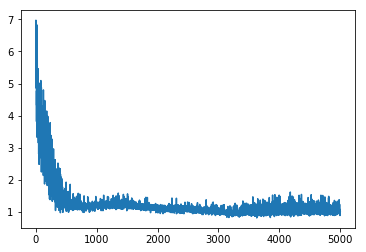

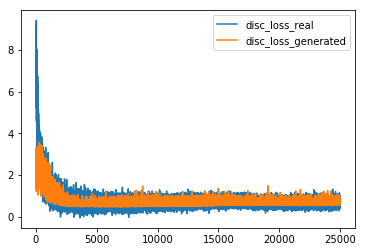

In [292]:
plt.plot( combined_loss[1:], label='combined_loss' ) ; plt.show()

plt.plot( disc_loss_real[1:], label='disc_loss_real' )
plt.plot( disc_loss_generated[1:], label='disc_loss_generated' )
plt.legend() ;

In [294]:
np.random.seed(17)

generator_input_tensor = layers.Input(shape=(rand_dim, ))
generated_image_tensor = generator_network(generator_input_tensor)
generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')

generator_model.load_weights('cache/CGAN_generator_model_weights_step_5000.h5')

temp_noise = np.random.normal(size=(batch_size, rand_dim))  # fixed noise to generate batches of generated images

g_z = generator_model.predict(temp_noise)

# g_z[0]


/opt/conda/lib/python3.6/site-packages/Keras-2.0.4-py3.6.egg/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


In [295]:
print( CheckAccuracy( generator_model, 100, train_w_class ) )

0.88


In [298]:
n_samples = 100

np.random.seed(0)
temp_noise = np.random.normal(size=(n_samples*2, rand_dim))  # fixed noise to generate batches of generated images
test_samples = generator_model.predict(temp_noise)
test_samples = np.reshape(test_samples, (n_samples*2, data_dim))
# test_samples = np.round(test_samples,3)
test_samples = pd.DataFrame(test_samples,columns=train_w_class.columns)
test_samples['syn_label'] = 1

test_samples['Class'] = (test_samples['Class'] > 0.5)*1

real_samples = train_w_class.sample(n_samples*2,replace=False)
# real_samples = test_w_class.sample(n_samples*2,replace=False)
real_samples['syn_label'] = 0

train_df = pd.concat([real_samples[:n_samples],test_samples[:n_samples]],axis=0)
test_df = pd.concat([real_samples[n_samples:],test_samples[n_samples:]],axis=0)

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)

xgb_params = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0 }
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred = np.round(xgb_test.predict(dtest))
y_true = test_df['syn_label']
'{:.2f}'.format(SimpleAccuracy(y_pred, y_true))

'0.88'

In [297]:
# For testing by class

n = 1
real_class = real_samples[ real_samples.Class == n ].reset_index(drop=True)
test_class = test_samples[ test_samples.Class == n ].reset_index(drop=True)

train_df = pd.concat( [ real_class[:len(real_class)//2], test_class[:len(test_class)//2] ],axis=0)
test_df = pd.concat(  [ real_class[len(real_class)//2:], test_class[len(test_class)//2:] ],axis=0)
print( real_class.shape, test_class.shape, train_df.shape, test_df.shape )

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)

xgb_params = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0 }
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred = np.round(xgb_test.predict(dtest))
y_true = test_df['syn_label']
'{:.2f}'.format(SimpleAccuracy(y_pred, y_true))

(100, 30) (80, 30) (90, 30) (90, 30)


'0.84'

In [299]:
# train_w_class.head(3)
# test_samples.head(3)
# real_samples.head(3)

In [300]:
# Evaluate performance on validation set
SimpleMetrics(y_pred,y_true)

Confusion Matrix


,Pred 0,Pred 1
True 0,90,10
True 1,15,85


Accuracy : 0.875


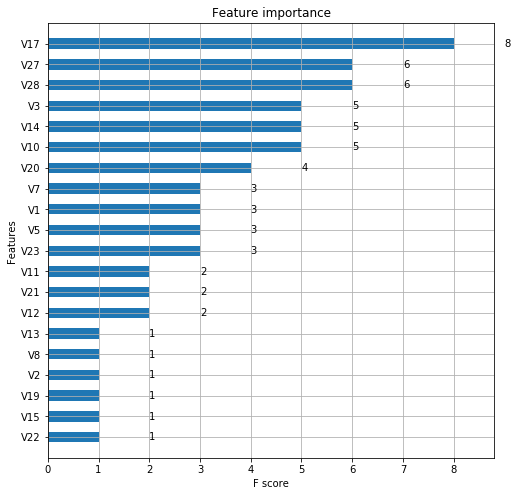

In [301]:
# Plot feature importances

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=20, height=0.5, ax=ax);

In [170]:
# # https://stackoverflow.com/questions/613183/sort-a-python-dictionary-by-value
# import operator
# x = xgb_test.get_fscore()
# sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
# # sorted_x

In [210]:
# for col, imp in sorted_x:
# # for col in xgb_model_DCGAN.get_fscore().keys():
# # for col in ['V1','V14','V3']:
#     plt.hist( [train_df[col][:100], train_df[col][100:]], label=['real','syn'], bins=20 )
# #     plt.title( '{}: {}'.format(col, xgb_model_DCGAN.get_fscore()[col]) )
#     plt.title( '{}: {}'.format(col, imp) )
#     plt.legend() ; plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


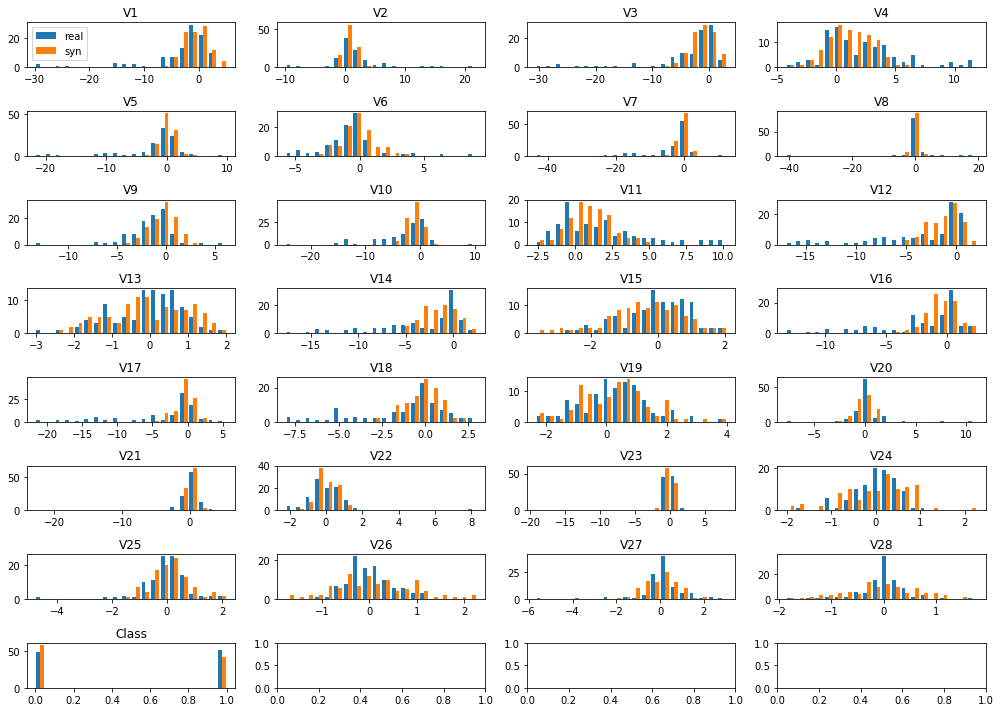

In [302]:
# for col in train.columns:
#     plt.hist( [train_df[col][:100], train_df[col][100:]], label=['real','syn'], bins=20 )
#     plt.title( '{}'.format(col) )
#     plt.legend() ; plt.show()
    
# plt.figure(figsize=(14,5))    
f, axarr = plt.subplots(8, 4, figsize=(14,10) )
for i in range(data_dim):
    col = train_df.columns[i]
#     axarr[i//4, i%4].hist( [train_df[col][:100], train_df[col][100:]], label=['real','syn'], bins=20 )
    axarr[i//4, i%4].hist( [ train_df.loc[train_df['syn_label']==0, col], train_df.loc[train_df['syn_label']==1, col]], 
                          label=['real','syn'], bins=20) #, normed=True )
    axarr[i//4, i%4].set_title( '{}'.format(col) )
    if i == 0: axarr[i//4, i%4].legend()
#     axarr[i//4, i%4].set_xlim([-0.1,1.1])
#     axarr[i//4, i%4].set_ylim([0,40])
f.set_tight_layout(True)

In [239]:
# train_df.groupby('syn_label')['V2'].describe()

<a id="Waya.ai WGAN dense"><h1>Waya.ai WGAN dense</h1></a>

<a href='#TOC'>Table of contents</a>

In [17]:
data_dim = 28

In [304]:
def adversarial_training(data_dir, generator_model_path, discriminator_model_path, evaluate=False):
    """
    Adversarial training of the generator network Gθ and discriminator network Dφ.

    """
    # Set random seed
    np.random.seed(5)
    
    #
    # define model input and output tensors
    #

    generator_input_tensor = layers.Input(shape=(rand_dim, ))
    generated_image_tensor = generator_network(generator_input_tensor)

    generated_or_real_image_tensor = layers.Input(shape=(data_dim,))
    discriminator_output = discriminator_network(generated_or_real_image_tensor)

    #
    # define models
    #

    generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')
    discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
                                       outputs=[discriminator_output],
                                       name='discriminator')

    combined_output = discriminator_model(generator_model(generator_input_tensor))
    combined_model = models.Model(inputs=[generator_input_tensor], outputs=[combined_output], name='combined')

    #
    # define earth mover distance (wasserstein loss)
    #

    def em_loss(y_coefficients, y_pred):
        return tf.reduce_mean(tf.multiply(y_coefficients, y_pred))

    #
    # construct computation graph for calculating the gradient penalty (improved wGAN) and training the discriminator
    #

    # sample a batch of noise (generator input)
    _z = tf.placeholder(tf.float32, shape=(batch_size, rand_dim))

    # sample a batch of real images
    _x = tf.placeholder(tf.float32, shape=(batch_size, data_dim))

    # generate a batch of images with the current generator
    _g_z = generator_model(_z)

    # calculate `x_hat`
    epsilon = tf.placeholder(tf.float32, shape=(batch_size, 1))
    x_hat = epsilon * _x + (1.0 - epsilon) * _g_z

    # gradient penalty
    gradients = tf.gradients(discriminator_model(x_hat), [x_hat])
    _gradient_penalty = 10.0 * tf.square(tf.norm(gradients[0], ord=2) - 1.0)

    # calculate discriminator's loss
    _disc_loss = em_loss(tf.ones(batch_size), discriminator_model(_g_z)) - \
        em_loss(tf.ones(batch_size), discriminator_model(_x)) + \
        _gradient_penalty

    # update φ by taking an SGD step on mini-batch loss LD(φ)
    disc_optimizer = tf.train.AdamOptimizer(learning_rate=.0001, beta1=0.5, beta2=0.9).minimize(
        _disc_loss, var_list=discriminator_model.trainable_weights)

    sess = K.get_session()

    #
    # compile models
    #

    adam = optimizers.Adam(lr=.0001, beta_1=0.5, beta_2=0.9)

    discriminator_model.trainable = False
    combined_model.compile(optimizer=adam, loss=[em_loss])

    print(generator_model.summary())
    print(discriminator_model.summary())
    print(combined_model.summary())

    disc_loss = []
    combined_loss = []
    xgb_losses = []

    def train_discriminator_step():
        d_l, _ = sess.run([_disc_loss, disc_optimizer], feed_dict={
            _z: np.random.normal(loc=0.0, scale=1.0, size=(batch_size, rand_dim)),
            _x: get_data_batch(train, batch_size, data_dim),
            epsilon: np.random.uniform(low=0.0, high=1.0, size=(batch_size, 1))
        })

        return d_l

    if generator_model_path:
        generator_model.load_weights(generator_model_path, by_name=True)
    if discriminator_model_path:
        discriminator_model.load_weights(discriminator_model_path, by_name=True)
    else:
        print('pre-training the critic...')
        K.set_learning_phase(1) # 1 = train
        for i in range(critic_pre_train_steps):
            print('Step: {} of {} critic pre-training.'.format(i, critic_pre_train_steps))
            loss = train_discriminator_step()

        print('Last batch of critic pre-training disc_loss: {}.'.format(loss))
        discriminator_model.save(os.path.join(cache_dir, 'WGAN_discriminator_model_pre_trained.h5'))

    for i in range(nb_steps):
        print('Step: {} of {}.'.format(i, nb_steps))
        K.set_learning_phase(1) # 1 = train
        # train the discriminator
        for _ in range(k_d):
#                 print('train the discriminator')
            # when plotting loss we will have to take `k_d` and `k_g` into account so the two plots align
            loss = train_discriminator_step()
            disc_loss.append(loss)
        # train the generator
        for _ in range(k_g):
#                 print('train the generator')
            z = np.random.normal(loc=0.0, scale=1.0, size=(batch_size, rand_dim))
            # update θ by taking an SGD step on mini-batch loss LG(θ)
            loss = combined_model.train_on_batch(z, [-np.ones(batch_size)])
            combined_loss.append(loss)

        if not i % log_interval and i != 0:
            K.set_learning_phase(0) # 0 = test

            g_z = generator_model.predict(fixed_noise)
            x = get_data_batch(train, batch_size, data_dim)

            # log loss summary
            print('Generator model loss: {}.'.format(np.mean(np.asarray(combined_loss[-log_interval:]), axis=0)))
            print('Discriminator model loss: {}.'.format(np.mean(np.asarray(disc_loss[-log_interval:]), axis=0)))

            xgb_loss = CheckAccuracy( generator_model, 100, train )
#             xgb_loss = CheckAccuracy( generator_model, 100, test )
            xgb_losses = np.append(xgb_losses, xgb_loss)
            print('xgboost accuracy: {}'.format(xgb_loss) )

            # save model checkpoints
            model_checkpoint_base_name = os.path.join(cache_dir, 'WGAN_{}_model_weights_step_{}.h5')
            generator_model.save_weights(model_checkpoint_base_name.format('generator', i))
            discriminator_model.save_weights(model_checkpoint_base_name.format('discriminator', i))
    
    pickle.dump([combined_loss, disc_loss, xgb_losses], 
                open(os.path.join(cache_dir, 'WGAN_losses.pkl'),'wb'))

In [305]:
%%time
K.set_learning_phase(1) # 1 = train
adversarial_training('', None, None)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        (None, 32)                0         
_________________________________________________________________
dense_185 (Dense)            (None, 32)                1056      
_________________________________________________________________
leaky_re_lu_130 (LeakyReLU)  (None, 32)                0         
_________________________________________________________________
dropout_130 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_186 (Dense)            (None, 32)                1056      
_________________________________________________________________
leaky_re_lu_131 (LeakyReLU)  (None, 32)                0         
_________________________________________________________________
dropout_131 (Dropout)        (None, 32)                0         
__________

/opt/conda/lib/python3.6/site-packages/Keras-2.0.4-py3.6.egg/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Step: 1 of 5001.
Step: 2 of 5001.
Step: 3 of 5001.
Step: 4 of 5001.
Step: 5 of 5001.
Step: 6 of 5001.
Step: 7 of 5001.
Step: 8 of 5001.
Step: 9 of 5001.
Step: 10 of 5001.
Generator model loss: -0.013435149565339088.
Discriminator model loss: 154.9313201904297.
xgboost accuracy: 0.97
Step: 11 of 5001.
Step: 12 of 5001.
Step: 13 of 5001.
Step: 14 of 5001.
Step: 15 of 5001.
Step: 16 of 5001.
Step: 17 of 5001.
Step: 18 of 5001.
Step: 19 of 5001.
Step: 20 of 5001.
Generator model loss: -0.009220552630722523.
Discriminator model loss: 118.15766906738281.
xgboost accuracy: 0.95
Step: 21 of 5001.
Step: 22 of 5001.
Step: 23 of 5001.
Step: 24 of 5001.
Step: 25 of 5001.
Step: 26 of 5001.
Step: 27 of 5001.
Step: 28 of 5001.
Step: 29 of 5001.
Step: 30 of 5001.
Generator model loss: 0.0011707473313435912.
Discriminator model loss: 89.83705139160156.
xgboost accuracy: 0.95
Step: 31 of 5001.
Step: 32 of 5001.
Step: 33 of 5001.
Step: 34 of 5001.
Step: 35 of 5001.
Step: 36 of 5001.
Step: 37 of 5001.
Ste

In [306]:
# for continued training
# adversarial_training('', 'cache/WGAN_generator_model_weights_step_100.h5', 'cache/WGAN_discriminator_model_weights_step_100.h5')

In [307]:
[combined_loss, disc_loss, xgb_losses] = pickle.load(open(os.path.join(cache_dir, 'WGAN_losses.pkl'),'rb'))

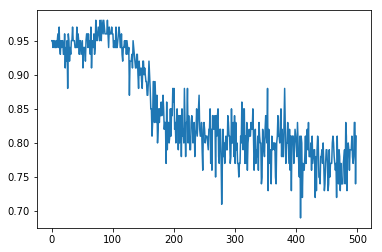

In [308]:
plt.plot( xgb_losses[1:] ) ;

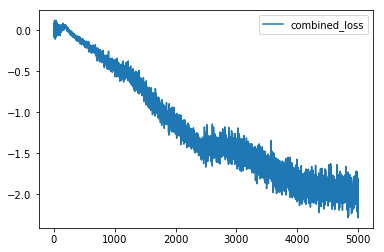

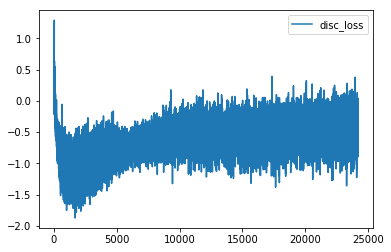

In [309]:
plt.plot( combined_loss[1:], label='combined_loss' ) ; plt.legend() ; plt.show()

plt.plot( disc_loss[800:], label='disc_loss' ) ; plt.legend() ;

In [311]:
np.random.seed(0)
    
generator_input_tensor = layers.Input(shape=(rand_dim, ))
generated_image_tensor = generator_network(generator_input_tensor)
generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')

generator_model.load_weights('cache/WGAN_generator_model_weights_step_5000.h5')

temp_noise = np.random.normal(size=(batch_size, rand_dim))  # fixed noise to generate batches of generated images

g_z = generator_model.predict(temp_noise)

# g_z[0]


/opt/conda/lib/python3.6/site-packages/Keras-2.0.4-py3.6.egg/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


In [312]:
print( CheckAccuracy( generator_model, 100, train ) )

0.80


In [320]:
n_samples = 100

np.random.seed(0)
temp_noise = np.random.normal(size=(n_samples*2, rand_dim))  # fixed noise to generate batches of generated images
test_samples = generator_model.predict(temp_noise)
test_samples = np.reshape(test_samples, (n_samples*2, data_dim))
test_samples = pd.DataFrame(test_samples,columns=train.columns)
test_samples['syn_label'] = 1

# real_samples = test.sample(n_samples*2,replace=False)
real_samples = train.sample(n_samples*2,replace=False)
real_samples['syn_label'] = 0

train_df = pd.concat([real_samples[:n_samples],test_samples[:n_samples]],axis=0)
test_df = pd.concat([real_samples[n_samples:],test_samples[n_samples:]],axis=0)

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)

xgb_params = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0 }
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred = np.round(xgb_test.predict(dtest))
y_true = test_df['syn_label']
'{:.2f}'.format(SimpleAccuracy(y_pred, y_true))

'0.80'

In [314]:
# Evaluate performance on validation set
SimpleMetrics(y_pred,y_true)

Confusion Matrix


,Pred 0,Pred 1
True 0,72,28
True 1,12,88


Accuracy : 0.8


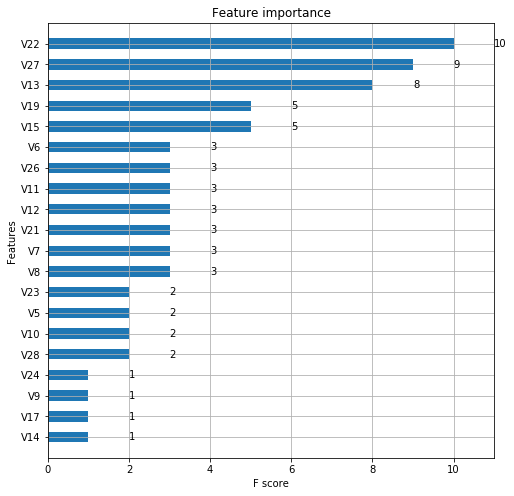

In [315]:
# Plot feature importances

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=20, height=0.5, ax=ax);

In [316]:
# # https://stackoverflow.com/questions/613183/sort-a-python-dictionary-by-value
# import operator
# x = xgb_test.get_fscore()
# sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
# # sorted_x

In [317]:
# for col, imp in sorted_x:
# # for col in xgb_model_DCGAN.get_fscore().keys():
# # for col in ['V1','V14','V3']:
#     plt.hist( [train_df[col][:100], train_df[col][100:]], label=['real','syn'], bins=20 )
# #     plt.title( '{}: {}'.format(col, xgb_model_DCGAN.get_fscore()[col]) )
#     plt.title( '{}: {}'.format(col, imp) )
#     plt.legend() ; plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


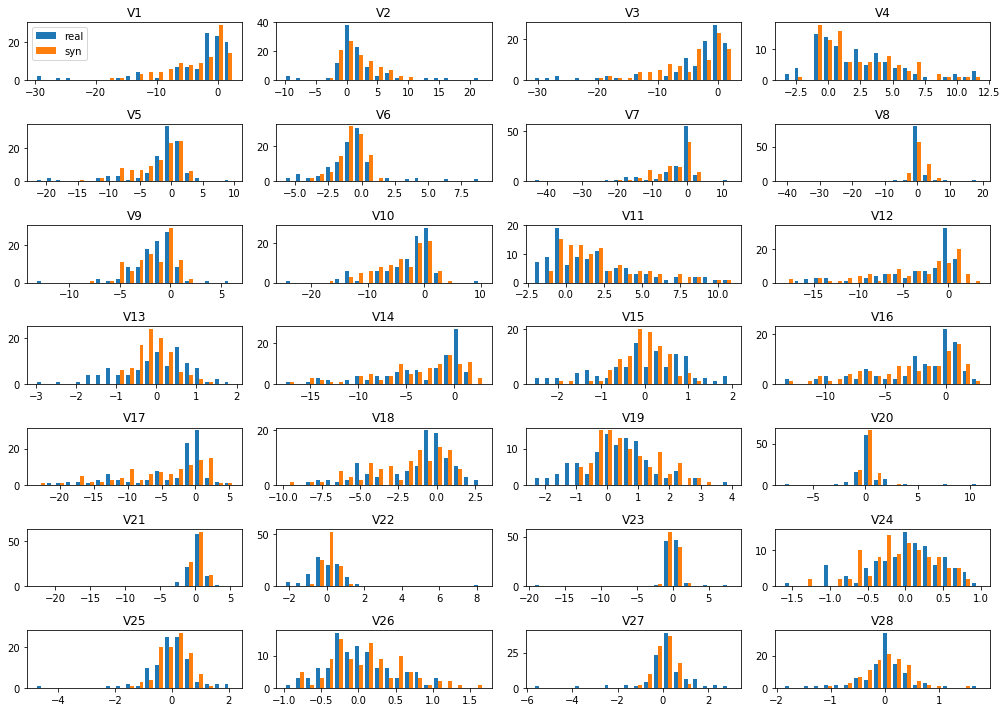

In [318]:
# for col in train.columns:
#     plt.hist( [train_df[col][:100], train_df[col][100:]], label=['real','syn'], bins=20 )
#     plt.title( '{}'.format(col) )
#     plt.legend() ; plt.show()
    
# plt.figure(figsize=(14,5))    
f, axarr = plt.subplots(7, 4, figsize=(14,10) )
for i in range(28):
    col = train_df.columns[i]
    axarr[i//4, i%4].hist( [train_df[col][:100], train_df[col][100:]], label=['real','syn'], bins=20 )
    axarr[i//4, i%4].set_title( '{}'.format(col) )
    if i == 0: axarr[i//4, i%4].legend()
#     axarr[i//4, i%4].set_xlim([-0.1,1.1])
#     axarr[i//4, i%4].set_ylim([0,40])
f.set_tight_layout(True)

<a id="Waya.ai WCGAN dense"><h1>Waya.ai WCGAN dense</h1></a>

<a href='#TOC'>Table of contents</a>

In [321]:
data_dim = 29 # Add 1 for class label

In [322]:
def adversarial_training(data_dir, generator_model_path, discriminator_model_path, evaluate=False):
    """
    Adversarial training of the generator network Gθ and discriminator network Dφ.

    """
    # set random seed
    np.random.seed(5)
    
    #
    # define model input and output tensors
    #

    generator_input_tensor = layers.Input(shape=(rand_dim, ))
    generated_image_tensor = generator_network(generator_input_tensor)

    generated_or_real_image_tensor = layers.Input(shape=(data_dim,))
    discriminator_output = discriminator_network(generated_or_real_image_tensor)

    #
    # define models
    #

    generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')
    discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
                                       outputs=[discriminator_output],
                                       name='discriminator')

    combined_output = discriminator_model(generator_model(generator_input_tensor))
    combined_model = models.Model(inputs=[generator_input_tensor], outputs=[combined_output], name='combined')

    #
    # define earth mover distance (wasserstein loss)
    #

    def em_loss(y_coefficients, y_pred):
        return tf.reduce_mean(tf.multiply(y_coefficients, y_pred))

    #
    # construct computation graph for calculating the gradient penalty (improved wGAN) and training the discriminator
    #

    # sample a batch of noise (generator input)
    _z = tf.placeholder(tf.float32, shape=(batch_size, rand_dim))

    # sample a batch of real images
    _x = tf.placeholder(tf.float32, shape=(batch_size, data_dim))

    # generate a batch of images with the current generator
    _g_z = generator_model(_z)

    # calculate `x_hat`
    epsilon = tf.placeholder(tf.float32, shape=(batch_size, 1))
    x_hat = epsilon * _x + (1.0 - epsilon) * _g_z

    # gradient penalty
    gradients = tf.gradients(discriminator_model(x_hat), [x_hat])
    _gradient_penalty = 10.0 * tf.square(tf.norm(gradients[0], ord=2) - 1.0)

    # calculate discriminator's loss
    _disc_loss = em_loss(tf.ones(batch_size), discriminator_model(_g_z)) - \
        em_loss(tf.ones(batch_size), discriminator_model(_x)) + \
        _gradient_penalty

    # update φ by taking an SGD step on mini-batch loss LD(φ)
    disc_optimizer = tf.train.AdamOptimizer(learning_rate=.0001, beta1=0.5, beta2=0.9).minimize(
        _disc_loss, var_list=discriminator_model.trainable_weights)

    sess = K.get_session()

    #
    # compile models
    #

    adam = optimizers.Adam(lr=.0001, beta_1=0.5, beta_2=0.9)

    discriminator_model.trainable = False
    combined_model.compile(optimizer=adam, loss=[em_loss])

    print(generator_model.summary())
    print(discriminator_model.summary())
    print(combined_model.summary())

    disc_loss = []
    combined_loss = []
    xgb_losses = []

    def train_discriminator_step():
        d_l, _ = sess.run([_disc_loss, disc_optimizer], feed_dict={
            _z: np.random.normal(loc=0.0, scale=1.0, size=(batch_size, rand_dim)),
            _x: get_data_batch(train_w_class, batch_size, data_dim),
            epsilon: np.random.uniform(low=0.0, high=1.0, size=(batch_size, 1))
        })

        return d_l

    if generator_model_path:
        generator_model.load_weights(generator_model_path, by_name=True)
    if discriminator_model_path:
        discriminator_model.load_weights(discriminator_model_path, by_name=True)
    else:
        print('pre-training the critic...')
        K.set_learning_phase(1) # 1 = train
        for i in range(critic_pre_train_steps):
            print('Step: {} of {} critic pre-training.'.format(i, critic_pre_train_steps))
            loss = train_discriminator_step()

        print('Last batch of critic pre-training disc_loss: {}.'.format(loss))
        discriminator_model.save(os.path.join(cache_dir, 'WGAN_discriminator_model_pre_trained.h5'))

    
    for i in range(nb_steps):
        print('Step: {} of {}.'.format(i, nb_steps))
        K.set_learning_phase(1) # 1 = train
        # train the discriminator
        for _ in range(k_d):
#                 print('train the discriminator')
            # when plotting loss we will have to take `k_d` and `k_g` into account so the two plots align
            loss = train_discriminator_step()
            disc_loss.append(loss)
        # train the generator
        for _ in range(k_g):
#                 print('train the generator')
            z = np.random.normal(loc=0.0, scale=1.0, size=(batch_size, rand_dim))
            # update θ by taking an SGD step on mini-batch loss LG(θ)
            loss = combined_model.train_on_batch(z, [-np.ones(batch_size)])
            combined_loss.append(loss)

        if not i % log_interval and i != 0:
            K.set_learning_phase(0) # 0 = test
                        
            # log loss summary
            print('Generator model loss: {}.'.format(np.mean(np.asarray(combined_loss[-log_interval:]), axis=0)))
            print('Discriminator model loss: {}.'.format(np.mean(np.asarray(disc_loss[-log_interval:]), axis=0)))

            xgb_loss = CheckAccuracy( generator_model, 100, train_w_class )
            xgb_losses = np.append(xgb_losses, xgb_loss)
            print('xgboost accuracy: {}'.format(xgb_loss) )

            # save model checkpoints
            model_checkpoint_base_name = os.path.join(cache_dir, 'WCGAN_{}_model_weights_step_{}.h5')
            generator_model.save_weights(model_checkpoint_base_name.format('generator', i))
            discriminator_model.save_weights(model_checkpoint_base_name.format('discriminator', i))
    
    pickle.dump([combined_loss, disc_loss, xgb_losses], 
                open(os.path.join(cache_dir, 'WCGAN_losses.pkl'),'wb'))

In [323]:
%%time
K.set_learning_phase(1) # 1 = train
adversarial_training('', None, None)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        (None, 32)                0         
_________________________________________________________________
dense_198 (Dense)            (None, 32)                1056      
_________________________________________________________________
leaky_re_lu_139 (LeakyReLU)  (None, 32)                0         
_________________________________________________________________
dropout_139 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_199 (Dense)            (None, 32)                1056      
_________________________________________________________________
leaky_re_lu_140 (LeakyReLU)  (None, 32)                0         
_________________________________________________________________
dropout_140 (Dropout)        (None, 32)                0         
__________

/opt/conda/lib/python3.6/site-packages/Keras-2.0.4-py3.6.egg/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Step: 1 of 5001.
Step: 2 of 5001.
Step: 3 of 5001.
Step: 4 of 5001.
Step: 5 of 5001.
Step: 6 of 5001.
Step: 7 of 5001.
Step: 8 of 5001.
Step: 9 of 5001.
Step: 10 of 5001.
Generator model loss: -0.07931115478277206.
Discriminator model loss: 144.3812255859375.
xgboost accuracy: 0.95
Step: 11 of 5001.
Step: 12 of 5001.
Step: 13 of 5001.
Step: 14 of 5001.
Step: 15 of 5001.
Step: 16 of 5001.
Step: 17 of 5001.
Step: 18 of 5001.
Step: 19 of 5001.
Step: 20 of 5001.
Generator model loss: -0.10240743309259415.
Discriminator model loss: 107.94306945800781.
xgboost accuracy: 0.96
Step: 21 of 5001.
Step: 22 of 5001.
Step: 23 of 5001.
Step: 24 of 5001.
Step: 25 of 5001.
Step: 26 of 5001.
Step: 27 of 5001.
Step: 28 of 5001.
Step: 29 of 5001.
Step: 30 of 5001.
Generator model loss: -0.05425948649644852.
Discriminator model loss: 82.80374908447266.
xgboost accuracy: 0.94
Step: 31 of 5001.
Step: 32 of 5001.
Step: 33 of 5001.
Step: 34 of 5001.
Step: 35 of 5001.
Step: 36 of 5001.
Step: 37 of 5001.
Step: 

In [324]:
# for continued training
# adversarial_training('', 'cache/WCGAN_generator_model_weights_step_100.h5', 'cache/WCGAN_discriminator_model_weights_step_100.h5')

In [325]:
[combined_loss, disc_loss, xgb_losses] = pickle.load(open(os.path.join(cache_dir, 'WCGAN_losses.pkl'),'rb'))

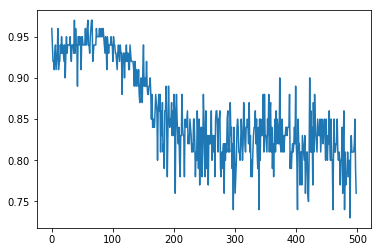

In [326]:
plt.plot( xgb_losses[1:] ) ;

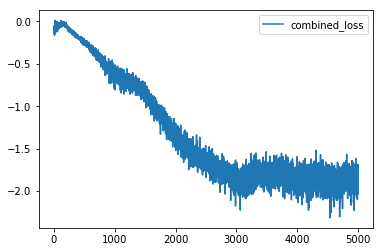

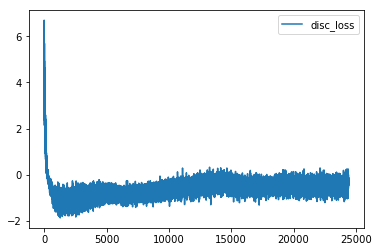

In [327]:
plt.plot( combined_loss[1:], label='combined_loss' ) ; plt.legend() ; plt.show()

plt.plot( disc_loss[600:], label='disc_loss' ) ; plt.legend() ;

In [328]:
np.random.seed(17)

generator_input_tensor = layers.Input(shape=(rand_dim, ))
generated_image_tensor = generator_network(generator_input_tensor)
generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')

generator_model.load_weights('cache/WCGAN_generator_model_weights_step_5000.h5')

temp_noise = np.random.normal(size=(batch_size, rand_dim))  # fixed noise to generate batches of generated images

g_z = generator_model.predict(temp_noise)

# g_z[0]


/opt/conda/lib/python3.6/site-packages/Keras-2.0.4-py3.6.egg/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


In [329]:
print( CheckAccuracy( generator_model, 100, train_w_class ) )

0.86


In [333]:
n_samples = 100

np.random.seed(0)
temp_noise = np.random.normal(size=(n_samples*2, rand_dim))  # fixed noise to generate batches of generated images
test_samples = generator_model.predict(temp_noise)
test_samples = np.reshape(test_samples, (n_samples*2, data_dim))
# test_samples = np.round(test_samples,3)
test_samples = pd.DataFrame(test_samples,columns=train_w_class.columns)
test_samples['syn_label'] = 1

test_samples['Class'] = (test_samples['Class'] > 0.5)*1

real_samples = train_w_class.sample(n_samples*2,replace=False)
# real_samples = test_w_class.sample(n_samples*2,replace=False)
real_samples['syn_label'] = 0

train_df = pd.concat([real_samples[:n_samples],test_samples[:n_samples]],axis=0)
test_df = pd.concat([real_samples[n_samples:],test_samples[n_samples:]],axis=0)

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)

xgb_params = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0 }
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred = np.round(xgb_test.predict(dtest))
y_true = test_df['syn_label']
'{:.2f}'.format(SimpleAccuracy(y_pred, y_true))

'0.86'

In [166]:
# For testing by class

n = 1
real_class = real_samples[ real_samples.Class == n ].reset_index(drop=True)
test_class = test_samples[ test_samples.Class == n ].reset_index(drop=True)

train_df = pd.concat( [ real_class[:len(real_class)//2], test_class[:len(test_class)//2] ],axis=0)
test_df = pd.concat(  [ real_class[len(real_class)//2:], test_class[len(test_class)//2:] ],axis=0)
print( real_class.shape, test_class.shape, train_df.shape, test_df.shape )

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)

xgb_params = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0 }
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred = np.round(xgb_test.predict(dtest))
y_true = test_df['syn_label']
'{:.2f}'.format(SimpleAccuracy(y_pred, y_true))

(200, 30) (81, 30) (140, 30) (141, 30)


'0.97'

In [331]:
# train_w_class.head(3)
# test_samples.head(3)
# real_samples.head(3)

In [334]:
# Evaluate performance on validation set
SimpleMetrics(y_pred,y_true)

Confusion Matrix


,Pred 0,Pred 1
True 0,84,16
True 1,11,89


Accuracy : 0.865


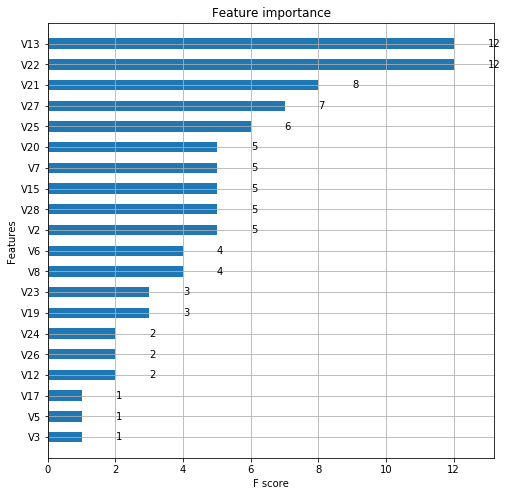

In [335]:
# Plot feature importances

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=20, height=0.5, ax=ax);

In [170]:
# # https://stackoverflow.com/questions/613183/sort-a-python-dictionary-by-value
# import operator
# x = xgb_test.get_fscore()
# sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
# # sorted_x

In [210]:
# for col, imp in sorted_x:
# # for col in xgb_model_DCGAN.get_fscore().keys():
# # for col in ['V1','V14','V3']:
#     plt.hist( [train_df[col][:100], train_df[col][100:]], label=['real','syn'], bins=20 )
# #     plt.title( '{}: {}'.format(col, xgb_model_DCGAN.get_fscore()[col]) )
#     plt.title( '{}: {}'.format(col, imp) )
#     plt.legend() ; plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


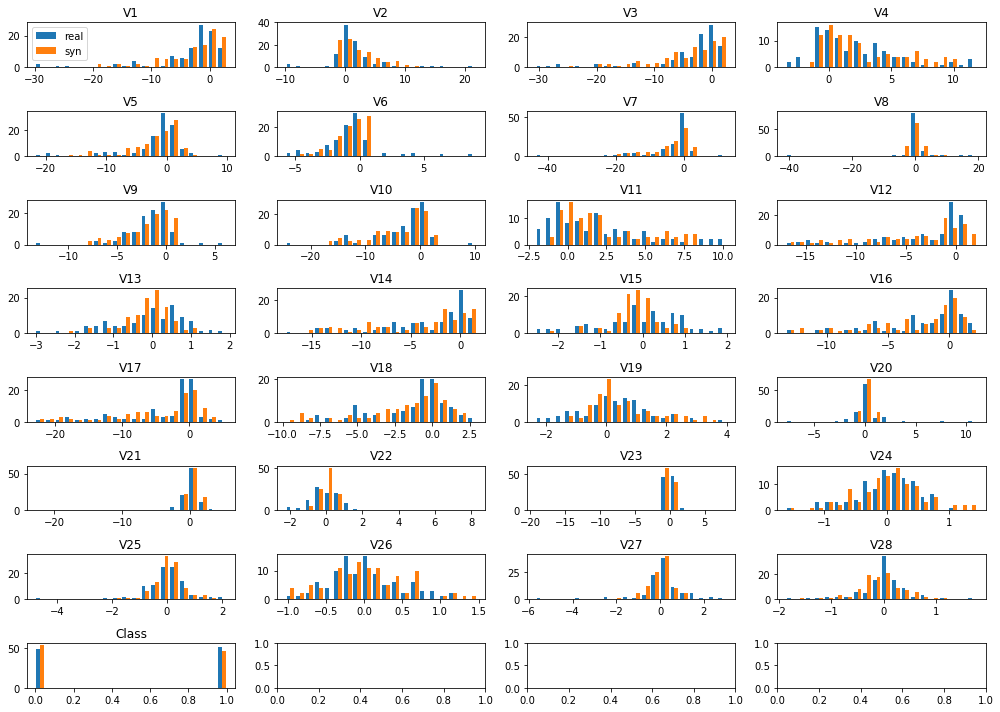

In [336]:
# for col in train.columns:
#     plt.hist( [train_df[col][:100], train_df[col][100:]], label=['real','syn'], bins=20 )
#     plt.title( '{}'.format(col) )
#     plt.legend() ; plt.show()
    
# plt.figure(figsize=(14,5))    
f, axarr = plt.subplots(8, 4, figsize=(14,10) )
for i in range(data_dim):
    col = train_df.columns[i]
#     axarr[i//4, i%4].hist( [train_df[col][:100], train_df[col][100:]], label=['real','syn'], bins=20 )
    axarr[i//4, i%4].hist( [ train_df.loc[train_df['syn_label']==0, col], train_df.loc[train_df['syn_label']==1, col]], 
                          label=['real','syn'], bins=20) #, normed=True )
    axarr[i//4, i%4].set_title( '{}'.format(col) )
    if i == 0: axarr[i//4, i%4].legend()
#     axarr[i//4, i%4].set_xlim([-0.1,1.1])
#     axarr[i//4, i%4].set_ylim([0,40])
f.set_tight_layout(True)

In [239]:
# train_df.groupby('syn_label')['V2'].describe()

<a id="Summary"><h1>Summary</h1></a>

<a href='#TOC'>Table of contents</a>
<br><br>


In [18]:
[combined_loss, disc_loss_real, disc_loss_generated, xgb_losses] = pickle.load(open(os.path.join(cache_dir, 'GAN_losses.pkl'),'rb'))
GAN_losses = [combined_loss, disc_loss_real, disc_loss_generated, xgb_losses]

In [19]:
[combined_loss, disc_loss_real, disc_loss_generated, xgb_losses] = pickle.load(open(os.path.join(cache_dir, 'CGAN_losses.pkl'),'rb'))
CGAN_losses = [combined_loss, disc_loss_real, disc_loss_generated, xgb_losses]

In [20]:
[combined_loss, disc_loss, xgb_losses] = pickle.load(open(os.path.join(cache_dir, 'WGAN_losses.pkl'),'rb'))
WGAN_losses = [combined_loss, disc_loss, xgb_losses]

In [21]:
[combined_loss, disc_loss, xgb_losses] = pickle.load(open(os.path.join(cache_dir, 'WCGAN_losses.pkl'),'rb'))
WCGAN_losses = [combined_loss, disc_loss, xgb_losses]

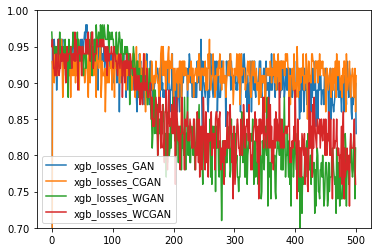

In [23]:
plt.plot( GAN_losses[-1], label='xgb_losses_GAN' )
plt.plot( CGAN_losses[-1], label='xgb_losses_CGAN' )
plt.plot( WGAN_losses[-1], label='xgb_losses_WGAN' )
plt.plot( WCGAN_losses[-1], label='xgb_losses_WCGAN' )
plt.ylim([0.7,1])
plt.legend() ;

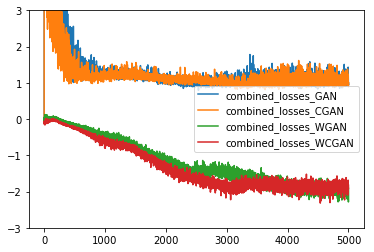

In [24]:
plt.plot( GAN_losses[0], label='combined_losses_GAN' )
plt.plot( CGAN_losses[0], label='combined_losses_CGAN' )
plt.plot( WGAN_losses[0], label='combined_losses_WGAN' )
plt.plot( WCGAN_losses[0], label='combined_losses_WCGAN' )
plt.ylim([-3,3])
plt.legend() ;

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


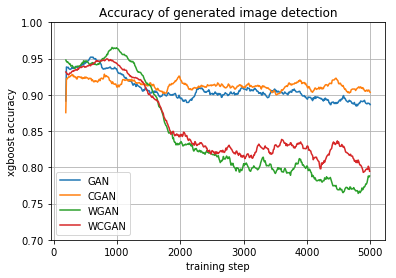

In [39]:
# plt.plot( pd.rolling_mean(GAN_losses[0],10) )
w = 20
plt.plot( list(range(0,5001,10)), pd.rolling_mean(GAN_losses[-1],w), label='GAN' )
plt.plot( list(range(0,5001,10)), pd.rolling_mean(CGAN_losses[-1],w), label='CGAN' )
plt.plot( list(range(1,5001,10)), pd.rolling_mean(WGAN_losses[-1],w), label='WGAN' )
plt.plot( list(range(1,5001,10)), pd.rolling_mean(WCGAN_losses[-1],w), label='WCGAN' )
plt.ylim([0.7,1])
plt.grid()
plt.title('Accuracy of generated image detection')
plt.xlabel('training step')
plt.ylabel('xgboost accuracy')
plt.legend()
plt.tight_layout
plt.savefig('plots/GAN_accuracy.png')

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


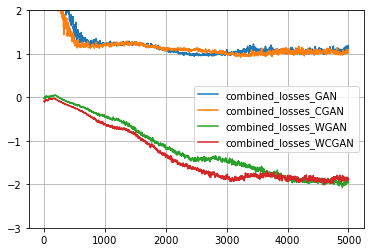

In [26]:
plt.plot( pd.rolling_mean(GAN_losses[0],10), label='combined_losses_GAN' )
plt.plot( pd.rolling_mean(CGAN_losses[0],10), label='combined_losses_CGAN' )
plt.plot( pd.rolling_mean(np.array(WGAN_losses[0]),10), label='combined_losses_WGAN' )
plt.plot( pd.rolling_mean(np.array(WCGAN_losses[0]),10), label='combined_losses_WCGAN' )
plt.ylim([-3,2])
plt.grid()
plt.legend() ;